# Notebook 2: Trying with last 10 days input data

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


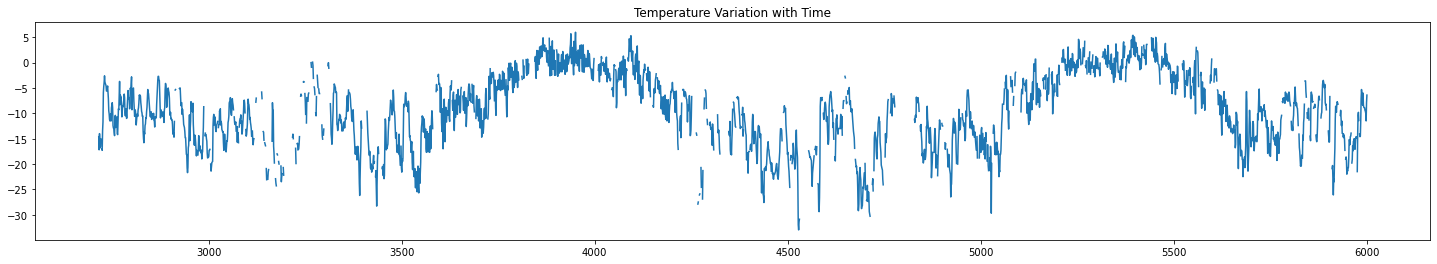

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=5):
    df = dataframe.copy()
    for lag in range(1, prev_n_days+1):
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=10)

In [11]:
y

array([ -4.3,  -4.6,  -5.6, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[ -4.1],
        [ -3.8],
        [ -2.6],
        ...,
        [-13.4],
        [-17.3],
        [-17. ]],

       [[ -4.3],
        [ -4.1],
        [ -3.8],
        ...,
        [-11.7],
        [-13.4],
        [-17.3]],

       [[ -4.6],
        [ -4.3],
        [ -4.1],
        ...,
        [ -5.9],
        [-11.7],
        [-13.4]],

       ...,

       [[-10. ],
        [ -9.6],
        [ -9.4],
        ...,
        [ -6. ],
        [ -8.4],
        [ -6.8]],

       [[-11.5],
        [-10. ],
        [ -9.6],
        ...,
        [ -8.4],
        [ -6. ],
        [ -8.4]],

       [[ -7.9],
        [-11.5],
        [-10. ],
        ...,
        [ -8.8],
        [ -8.4],
        [ -6. ]]])

# Temporal splitting

In [13]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

953 1157


# Standardization

In [14]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [15]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [16]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs1',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [17]:
model1 = Sequential()
model1.add(InputLayer((10,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [19]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 142.5046 - root_mean_squared_error: 11.9375

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 19s 482ms/step - loss: 142.5046 - root_mean_squared_error: 11.9375 - val_loss: 65.7076 - val_root_mean_squared_error: 8.1060
Epoch 2/50
28/30 [===========================>..] - ETA: 0s - loss: 97.2238 - root_mean_squared_error: 9.8602  

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 421ms/step - loss: 95.7706 - root_mean_squared_error: 9.7862 - val_loss: 37.2817 - val_root_mean_squared_error: 6.1059
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 45.5844 - root_mean_squared_error: 6.7516

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 13s 453ms/step - loss: 45.5844 - root_mean_squared_error: 6.7516 - val_loss: 19.6124 - val_root_mean_squared_error: 4.4286
Epoch 4/50
28/30 [===========================>..] - ETA: 0s - loss: 25.0013 - root_mean_squared_error: 5.0001

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 13s 463ms/step - loss: 25.4473 - root_mean_squared_error: 5.0445 - val_loss: 14.0152 - val_root_mean_squared_error: 3.7437
Epoch 5/50
30/30 [==============================] - ETA: 0s - loss: 17.2837 - root_mean_squared_error: 4.1574

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 401ms/step - loss: 17.2837 - root_mean_squared_error: 4.1574 - val_loss: 10.9495 - val_root_mean_squared_error: 3.3090
Epoch 6/50
29/30 [============================>.] - ETA: 0s - loss: 11.8990 - root_mean_squared_error: 3.4495

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 11s 391ms/step - loss: 11.9067 - root_mean_squared_error: 3.4506 - val_loss: 9.4045 - val_root_mean_squared_error: 3.0667
Epoch 7/50
24/30 [=======================>......] - ETA: 0s - loss: 8.3077 - root_mean_squared_error: 2.8823

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 406ms/step - loss: 8.6659 - root_mean_squared_error: 2.9438 - val_loss: 8.0499 - val_root_mean_squared_error: 2.8372
Epoch 8/50
29/30 [============================>.] - ETA: 0s - loss: 7.4043 - root_mean_squared_error: 2.7211

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 398ms/step - loss: 7.4278 - root_mean_squared_error: 2.7254 - val_loss: 7.6633 - val_root_mean_squared_error: 2.7683
Epoch 9/50
24/30 [=======================>......] - ETA: 0s - loss: 7.2670 - root_mean_squared_error: 2.6957

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 11s 392ms/step - loss: 6.8627 - root_mean_squared_error: 2.6197 - val_loss: 6.4979 - val_root_mean_squared_error: 2.5491
Epoch 10/50
30/30 [==============================] - ETA: 0s - loss: 6.1555 - root_mean_squared_error: 2.4810

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 399ms/step - loss: 6.1555 - root_mean_squared_error: 2.4810 - val_loss: 6.1574 - val_root_mean_squared_error: 2.4814
Epoch 11/50
30/30 [==============================] - ETA: 0s - loss: 5.7539 - root_mean_squared_error: 2.3987

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 11s 394ms/step - loss: 5.7539 - root_mean_squared_error: 2.3987 - val_loss: 5.7701 - val_root_mean_squared_error: 2.4021
Epoch 12/50
25/30 [========================>.....] - ETA: 0s - loss: 5.4639 - root_mean_squared_error: 2.3375

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 404ms/step - loss: 5.5356 - root_mean_squared_error: 2.3528 - val_loss: 5.6765 - val_root_mean_squared_error: 2.3825
Epoch 13/50
25/30 [========================>.....] - ETA: 0s - loss: 5.5539 - root_mean_squared_error: 2.3567

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 398ms/step - loss: 5.4340 - root_mean_squared_error: 2.3311 - val_loss: 5.5291 - val_root_mean_squared_error: 2.3514
Epoch 14/50
29/30 [============================>.] - ETA: 0s - loss: 5.2443 - root_mean_squared_error: 2.2900

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 401ms/step - loss: 5.2329 - root_mean_squared_error: 2.2876 - val_loss: 5.2342 - val_root_mean_squared_error: 2.2878
Epoch 15/50
29/30 [============================>.] - ETA: 0s - loss: 4.8691 - root_mean_squared_error: 2.2066

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 407ms/step - loss: 4.8752 - root_mean_squared_error: 2.2080 - val_loss: 5.2149 - val_root_mean_squared_error: 2.2836
Epoch 16/50
30/30 [==============================] - 0s 13ms/step - loss: 4.8781 - root_mean_squared_error: 2.2086 - val_loss: 5.3319 - val_root_mean_squared_error: 2.3091
Epoch 17/50
30/30 [==============================] - ETA: 0s - loss: 4.6884 - root_mean_squared_error: 2.1653

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 407ms/step - loss: 4.6884 - root_mean_squared_error: 2.1653 - val_loss: 4.9788 - val_root_mean_squared_error: 2.2313
Epoch 18/50
30/30 [==============================] - 0s 12ms/step - loss: 5.1347 - root_mean_squared_error: 2.2660 - val_loss: 5.2927 - val_root_mean_squared_error: 2.3006
Epoch 19/50
25/30 [========================>.....] - ETA: 0s - loss: 4.8044 - root_mean_squared_error: 2.1919

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 403ms/step - loss: 4.6693 - root_mean_squared_error: 2.1608 - val_loss: 4.7982 - val_root_mean_squared_error: 2.1905
Epoch 20/50
30/30 [==============================] - 0s 12ms/step - loss: 4.5758 - root_mean_squared_error: 2.1391 - val_loss: 4.9734 - val_root_mean_squared_error: 2.2301
Epoch 21/50
30/30 [==============================] - ETA: 0s - loss: 4.5625 - root_mean_squared_error: 2.1360

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 11s 394ms/step - loss: 4.5625 - root_mean_squared_error: 2.1360 - val_loss: 4.6961 - val_root_mean_squared_error: 2.1670
Epoch 22/50
30/30 [==============================] - 0s 17ms/step - loss: 4.4400 - root_mean_squared_error: 2.1071 - val_loss: 4.8741 - val_root_mean_squared_error: 2.2077
Epoch 23/50
30/30 [==============================] - 0s 13ms/step - loss: 4.1637 - root_mean_squared_error: 2.0405 - val_loss: 4.8407 - val_root_mean_squared_error: 2.2002
Epoch 24/50
30/30 [==============================] - 1s 18ms/step - loss: 4.3090 - root_mean_squared_error: 2.0758 - val_loss: 5.4665 - val_root_mean_squared_error: 2.3381
Epoch 25/50
27/30 [==========================>...] - ETA: 0s - loss: 4.6045 - root_mean_squared_error: 2.1458

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 11s 393ms/step - loss: 4.5726 - root_mean_squared_error: 2.1384 - val_loss: 4.6579 - val_root_mean_squared_error: 2.1582
Epoch 26/50
30/30 [==============================] - 0s 13ms/step - loss: 4.2107 - root_mean_squared_error: 2.0520 - val_loss: 5.2727 - val_root_mean_squared_error: 2.2962
Epoch 27/50
26/30 [=========================>....] - ETA: 0s - loss: 4.1655 - root_mean_squared_error: 2.0410

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 401ms/step - loss: 4.3058 - root_mean_squared_error: 2.0750 - val_loss: 4.5878 - val_root_mean_squared_error: 2.1419
Epoch 28/50
30/30 [==============================] - 0s 13ms/step - loss: 4.1663 - root_mean_squared_error: 2.0412 - val_loss: 4.6354 - val_root_mean_squared_error: 2.1530
Epoch 29/50
30/30 [==============================] - 0s 16ms/step - loss: 4.0316 - root_mean_squared_error: 2.0079 - val_loss: 4.9910 - val_root_mean_squared_error: 2.2341
Epoch 30/50
30/30 [==============================] - 1s 17ms/step - loss: 3.9614 - root_mean_squared_error: 1.9903 - val_loss: 5.0483 - val_root_mean_squared_error: 2.2468
Epoch 31/50
25/30 [========================>.....] - ETA: 0s - loss: 4.1091 - root_mean_squared_error: 2.0271

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 12s 413ms/step - loss: 4.1104 - root_mean_squared_error: 2.0274 - val_loss: 4.4665 - val_root_mean_squared_error: 2.1134
Epoch 32/50
30/30 [==============================] - 0s 15ms/step - loss: 3.9995 - root_mean_squared_error: 1.9999 - val_loss: 4.5426 - val_root_mean_squared_error: 2.1313
Epoch 33/50
30/30 [==============================] - 0s 15ms/step - loss: 3.8439 - root_mean_squared_error: 1.9606 - val_loss: 4.5423 - val_root_mean_squared_error: 2.1313
Epoch 34/50
30/30 [==============================] - 1s 22ms/step - loss: 3.8279 - root_mean_squared_error: 1.9565 - val_loss: 4.6977 - val_root_mean_squared_error: 2.1674
Epoch 35/50
30/30 [==============================] - 0s 12ms/step - loss: 3.7841 - root_mean_squared_error: 1.9453 - val_loss: 4.5739 - val_root_mean_squared_error: 2.1387
Epoch 36/50
29/30 [============================>.] - ETA: 0s - loss: 3.7327 - root_mean_squared_error: 1.9320

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


30/30 [==============================] - 14s 470ms/step - loss: 3.6944 - root_mean_squared_error: 1.9221 - val_loss: 4.3905 - val_root_mean_squared_error: 2.0954
Epoch 37/50
30/30 [==============================] - 0s 16ms/step - loss: 3.9483 - root_mean_squared_error: 1.9870 - val_loss: 4.6151 - val_root_mean_squared_error: 2.1483
Epoch 38/50
30/30 [==============================] - 0s 16ms/step - loss: 3.7724 - root_mean_squared_error: 1.9423 - val_loss: 4.6838 - val_root_mean_squared_error: 2.1642
Epoch 39/50
30/30 [==============================] - 1s 20ms/step - loss: 3.7785 - root_mean_squared_error: 1.9438 - val_loss: 4.4814 - val_root_mean_squared_error: 2.1169
Epoch 40/50
30/30 [==============================] - 0s 13ms/step - loss: 3.7487 - root_mean_squared_error: 1.9362 - val_loss: 4.6048 - val_root_mean_squared_error: 2.1459
Epoch 41/50
30/30 [==============================] - 0s 14ms/step - loss: 3.7851 - root_mean_squared_error: 1.9455 - val_loss: 4.4535 - val_root_mean_

In [20]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

30/30 [==============================] - 0s 4ms/step


In [23]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 3.104225324592648'}>

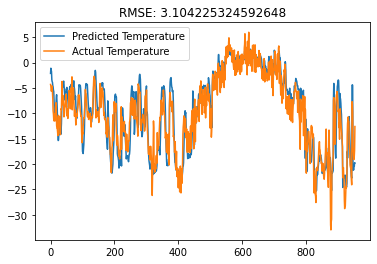

In [24]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.8019254817167223'}>

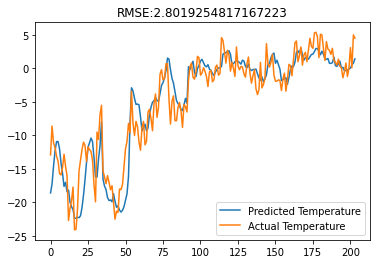

In [25]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:3.789929251477931'}>

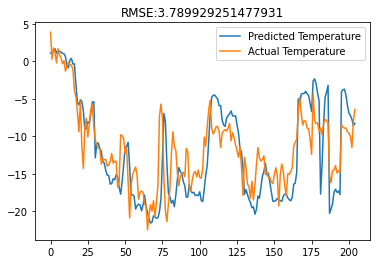

In [26]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


Increasing the number of input can lead to even less datapoints because the chance of finding a missing value in a sequence of length 11 is higher than that of length 5. RMSE improved slightly however. We will go with model 1 and meddel with this parameter once we establish other feature engineering tricks.
Adding n days from earlier could have been a good choice. Try to do it according to the perizicity. Like 1 to 7,13,14,15,20,21,22,27,28,29. This take 1 month major data into account along with the recent data. Try it as model 4